In [1]:
# Import necessary libraries 
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import glob
from sklearn.model_selection import train_test_split
import time
from numpy.random import shuffle
from scipy.ndimage.measurements import label
from sklearn.model_selection import GridSearchCV

In [2]:
# Define a function to display image
def plot_img(img, row=1, col=1, figsize=(12, 8)):
    f, ax1 = plt.subplots(row, col, sharey='col', sharex='row', figsize=figsize)
    f.tight_layout()
    ax1.imshow(img)
    plt.show()

# Define a function to convert image from RGB to different kinds of color space
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function that extract hog features from an image
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:     
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=False,
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=False,
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function that extracts raw pixel values as features
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

# Define a function that extracts color histogram as features
def color_hist(img, nbins=32):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Define a function to extract features from a list of images
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32), hist_bins=32,
                     orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # Apply color conversion if other than 'RGB':
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False and feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(0, feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], orient, 
                                                         pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient,
                                                pix_per_cell, cell_per_block,
                                                vis=False, feature_vec=True)
            # Append the new feature vector to the feature list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Randomly shuffle features data to avoid problems due to ordering of the data
    shuffle(features)
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    img = img.astype(np.float32)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None,None], y_start_stop=[None,None],
                 xy_window=(64,64), xy_overlap=(0.5,0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched 
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the length of each step
    x_step_length = (1 - xy_overlap[0]) * xy_window[0]
    y_step_length = (1 - xy_overlap[1]) * xy_window[1]
    # Compute the number of windows in x/y
    xn_windows = np.int((xspan - xy_window[0]) / x_step_length + 1)
    yn_windows = np.int((yspan - xy_window[1]) / y_step_length + 1)
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(yn_windows):
        starty = int(y_start_stop[0] + ys * y_step_length)
        endy = int(starty + xy_window[1])
        for xs in range(xn_windows):
            startx = int(x_start_stop[0] + xs * x_step_length)
            endx = int(startx + xy_window[0])
            # Append window position to the list
            window_list.append(((startx, starty), (endx, endy)))
    return window_list
        
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0,0,255), thick=6):
    im_copy = np.copy(img)
    for box in bboxes:
        cv2.rectangle(im_copy, box[0], box[1], color, thick)
    # return the image copy with boxes drawn
    return im_copy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32,32), hist_bins=32,
                   hist_range=(0,256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64,64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1,-1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


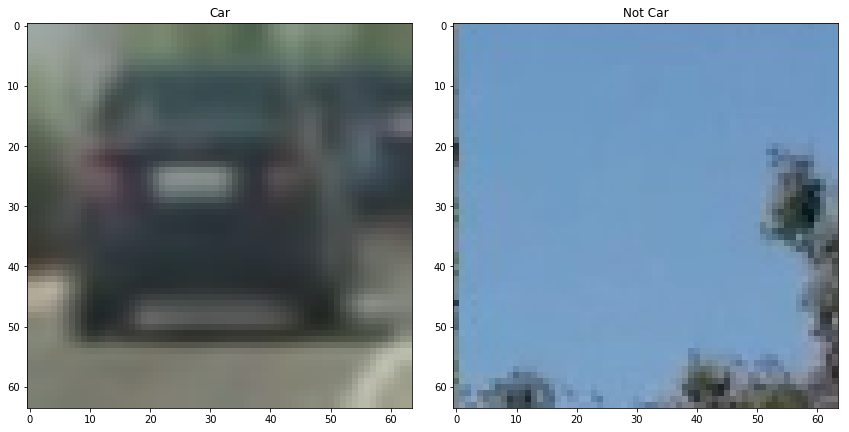

In [3]:
# Read in cars and notcars
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')
print('Number of Vehicle Images found:', len(cars))
print('Number of Non-Vehicle Images found:', len(notcars))
img1 = mpimg.imread(cars[0])
img2 = mpimg.imread(notcars[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title("Car")
ax2.imshow(img2)
ax2.set_title("Not Car")
plt.show()

In [4]:
# Extract car features and non-car features 
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 1 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space, spatial_size, hist_bins,
                                orient, pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat)
notcar_features = extract_features(notcars, color_space, spatial_size, hist_bins,
                                orient, pix_per_cell, cell_per_block, hog_channel,
                                spatial_feat, hist_feat, hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)

In [5]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC(C=0.5)
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

Using: 8 orientations 8 pixels per cell and 1 cells per block
Feature vector length: 4704
15.42 Seconds to train SVC...
Test Accuracy of SVC =  0.991


In [6]:
test_imgs = glob.glob('./test_images/*.jpg')
x_start_stop = [None, None]
y_start_stop = [400, 700]
xy_window = (96,96)
xy_overlap = (0.5,0.5)

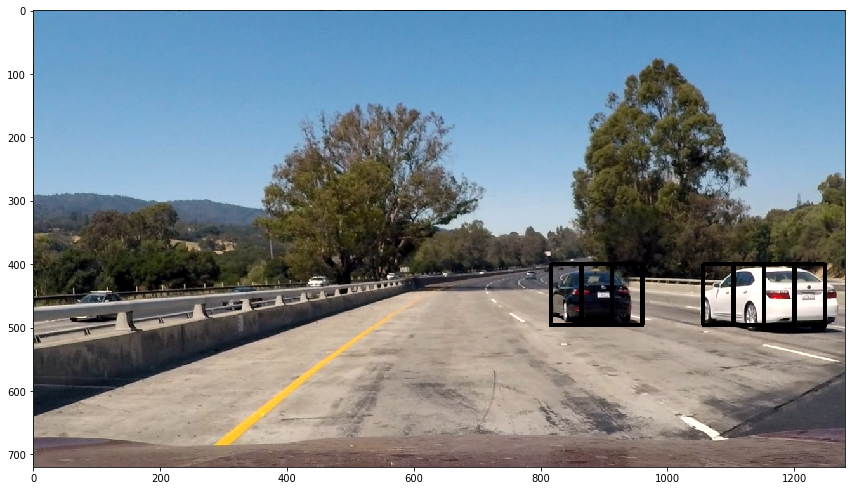

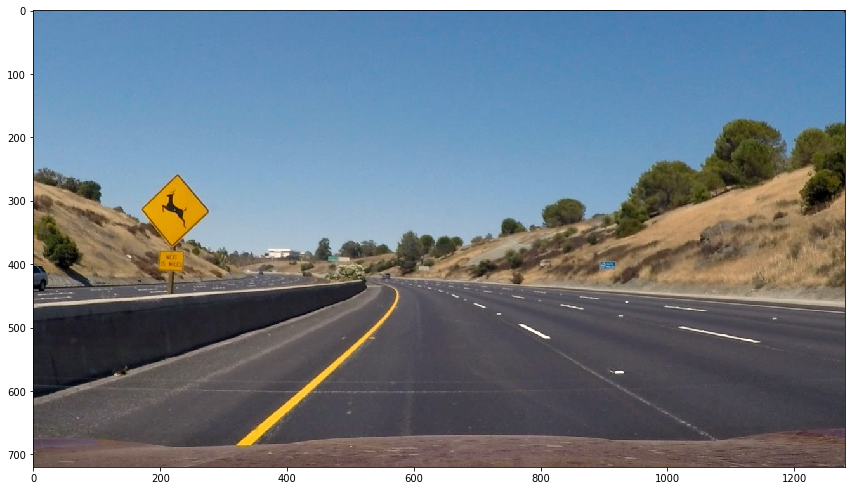

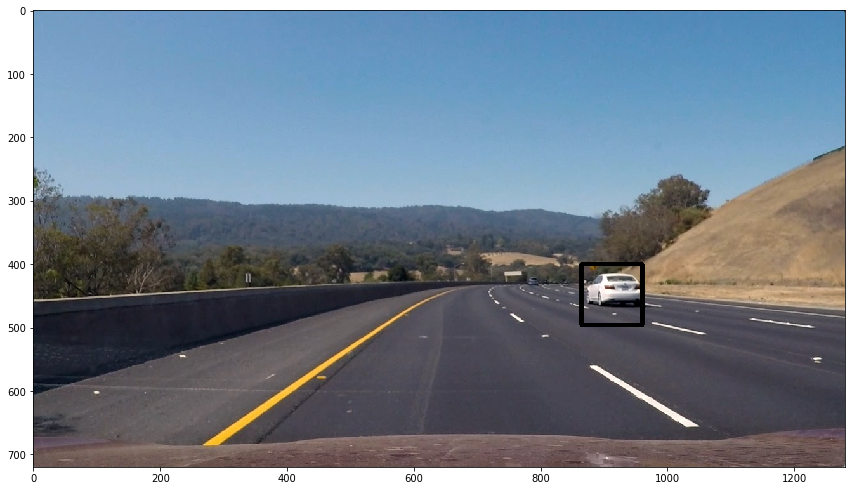

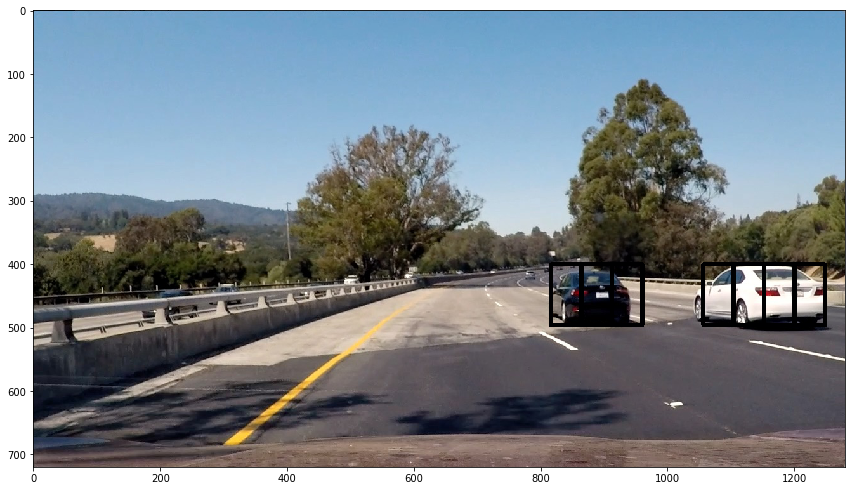

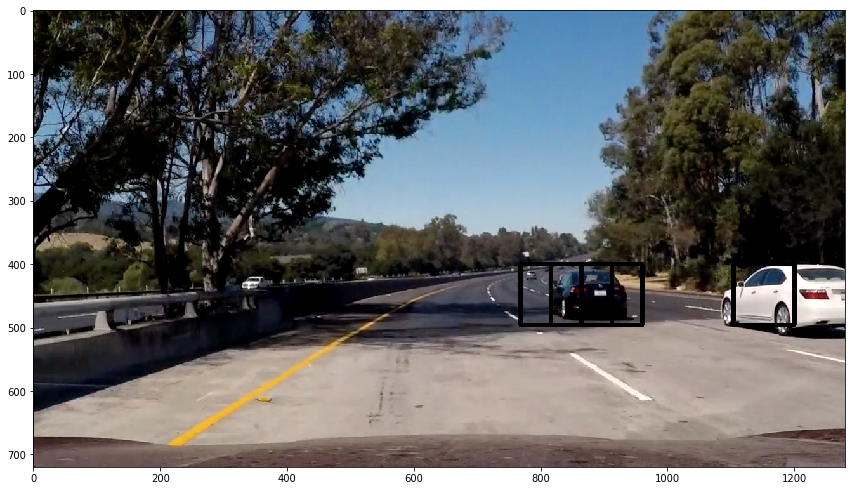

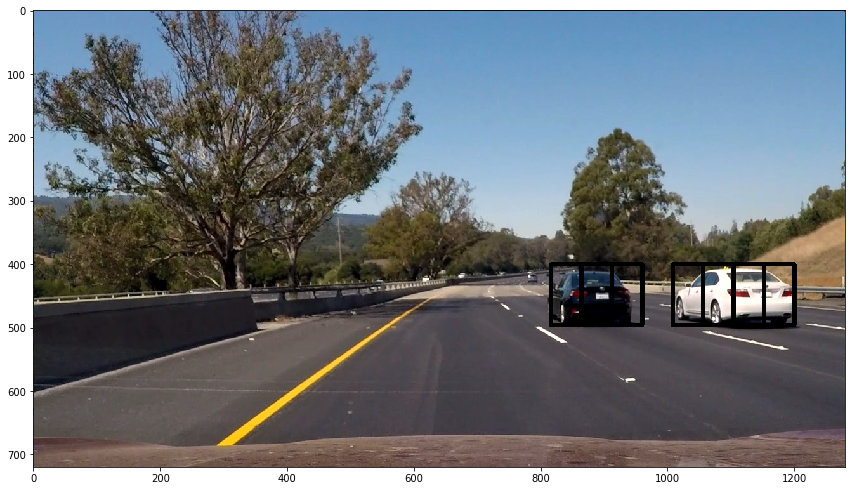

In [7]:
for file_img in test_imgs:
    img = mpimg.imread(file_img).astype(np.float32)/255
    draw_image = np.copy(img)
    img = draw_image
    
    windows = slide_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap)
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    window_img = draw_boxes(draw_image, hot_windows, color=(0,0,255), thick=6)
    plot_img(window_img)
    plt.show()

In [8]:
# Define a function that detects car based on the prediction model
def find_cars(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient,
              pix_per_cell, cell_per_block, spatial_size, hist_bins):

    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # Make a heatmap of zeros
    heatmap = np.zeros_like(img[:,:,0])
    img_tosearch = img[ystart : ystop, xstart : xstop, :]

    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2 # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            X = np.hstack((spatial_features, hist_features, hog_features))
            test_features = X_scaler.transform(X.reshape(1, -1))
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)
                heatmap[ytop_draw+ystart:ytop_draw+win_draw+ystart, xbox_left:xbox_left+win_draw] += 1
    return draw_img, heatmap

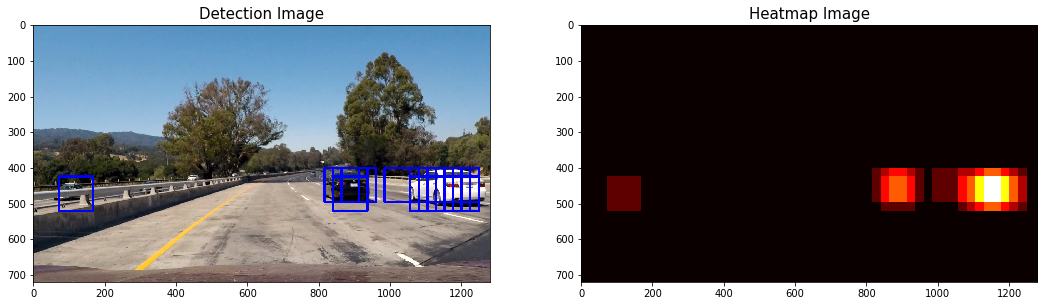

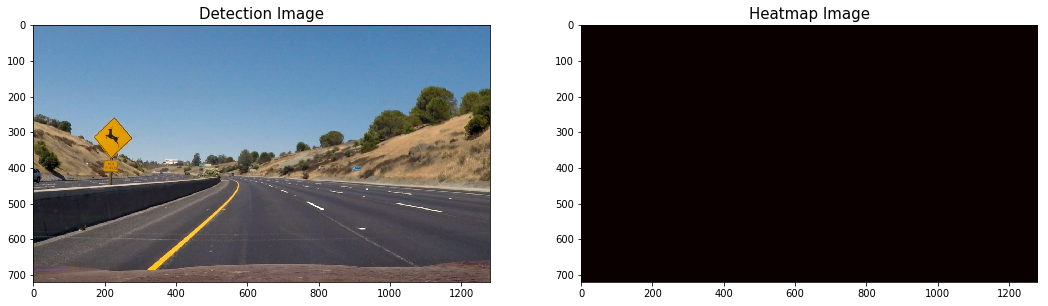

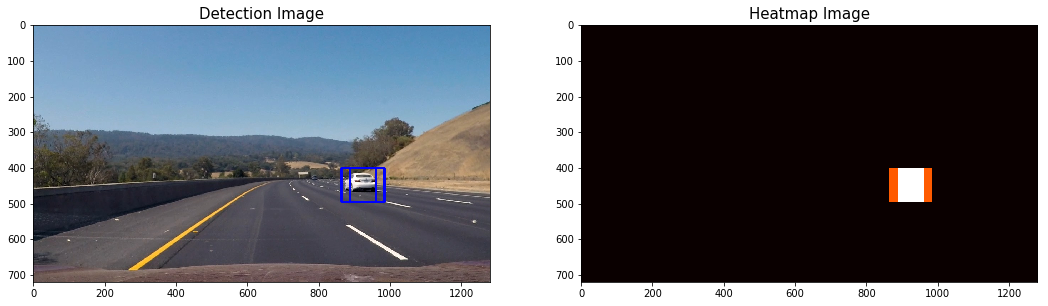

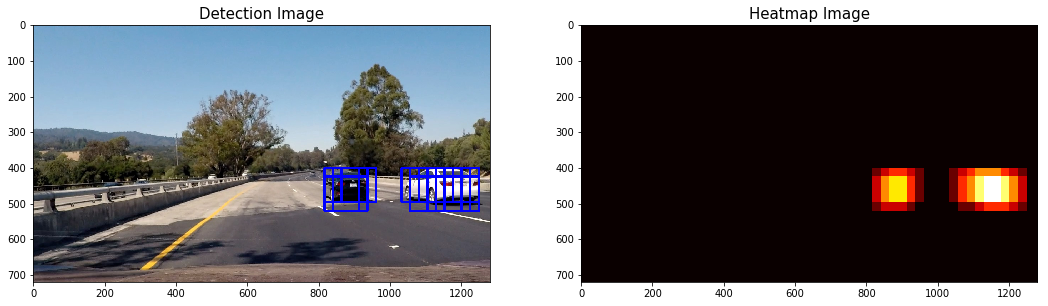

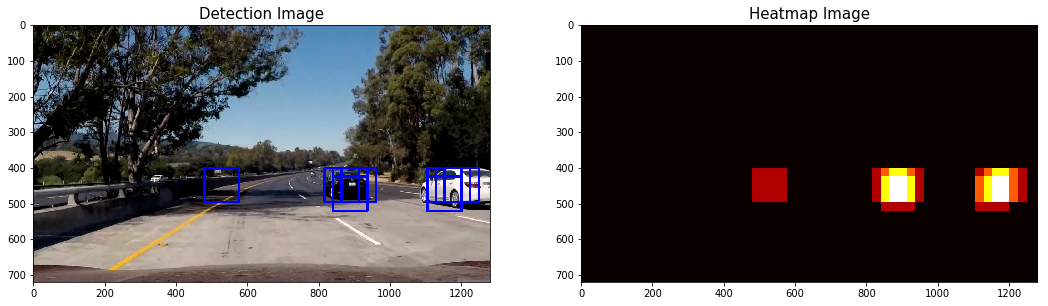

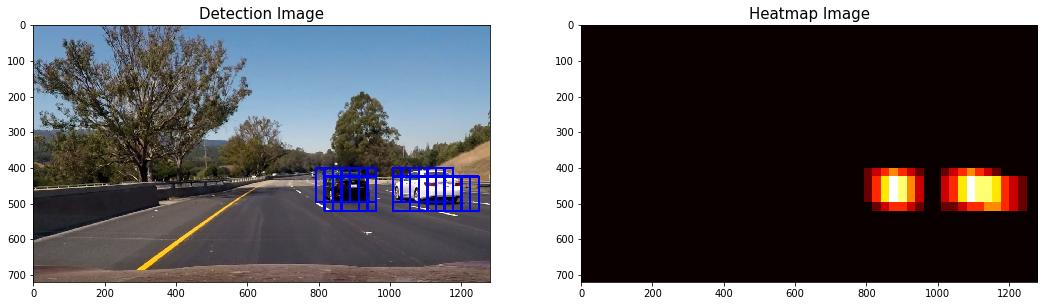

In [9]:
xstart = 0
xstop = 1280
ystart = 400
ystop = 700
scale = 1.5
test_imgs = glob.glob('./test_images/*.jpg')
for file_img in test_imgs:
    img = mpimg.imread(file_img)
    out_img, heatmap = find_cars(img, xstart, xstop, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,8))
    ax1.imshow(out_img)
    ax1.set_title("Detection Image", fontsize=15)
    ax2.imshow(heatmap, cmap="hot")
    ax2.set_title("Heatmap Image", fontsize=15)
    plt.show()

In [10]:
# Write a function that adds "heat" to a map for a list of bounding boxes
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap

# Write a function to threshold the map
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# Write a function that takes the labels image and put bounding boxes around the labeled regions
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        xmin = np.min(nonzerox)
        ymin = np.min(nonzeroy)
        xmax = np.max(nonzerox)
        ymax = np.max(nonzeroy)
        width = xmax - xmin
        height = ymax - ymin
        if (0.7 < width/height < 3.5):
            bbox = ((xmin, ymin), (xmax, ymax))
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [11]:
# Define a class to track car detection
class Detection():
    def __init__(self):
        self.last_frame_heat = None

In [12]:
# Define a function that returns boxes using different window sizes.
def get_labels(image, svc, X_scaler, color_space=color_space,
                spatial_size=spatial_size, hist_bins=hist_bins,
                orient=orient, pix_per_cell=pix_per_cell,
                cell_per_block=cell_per_block,
                hog_channel=hog_channel, spatial_feat=spatial_feat,
                hist_feat=hist_feat, hog_feat=hog_feat):
        
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    image = image.astype(np.float32)/255
    
    # Obtain windows given set of parameters
    expand = 1.25

    windows_64 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700],  #y_start_stop=[400, 598]
                               xy_window=(64*expand, 64), xy_overlap=(0.5*1.25, 0.5*1.25))
    windows_96 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700],  #y_start_stop=[400, 688]
                               xy_window=(96*expand, 96), xy_overlap=(0.5*1.25, 0.5*1.25))
    windows_128 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700], #y_start_stop=[444, 700]
                               xy_window=(128*expand, 128), xy_overlap=(0.5, 0.5))
    windows_194 = slide_window(image, x_start_stop=[600, 1280], y_start_stop=[400, 700], #y_start_stop=[409, 700]
                               xy_window=(194*expand, 194), xy_overlap=(0.5, 0.5))
    windows = []

    windows.extend(windows_64)
    windows.extend(windows_96)
    windows.extend(windows_128)
    windows.extend(windows_194)

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    # Add heat to each box in box list
    heats = add_heat(heatmap,hot_windows)

    # Apply threshold to help remove false positives
    heats = apply_threshold(heats,1)
    
    # Smoothing values from frame to frame
    if CarDetection.last_frame_heat != None:
        heats = np.round((CarDetection.last_frame_heat + heats)/2, 0)
    CarDetection.last_frame_heat = heats
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heats, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    return labels, heatmap



In [13]:
# Define a function that process an image for car detection
def process_image(image, svc=svc, X_scaler=X_scaler):
    labels, heatmap = get_labels(image, svc, X_scaler)
    draw_img = draw_labeled_bboxes(image, labels)
    return draw_img

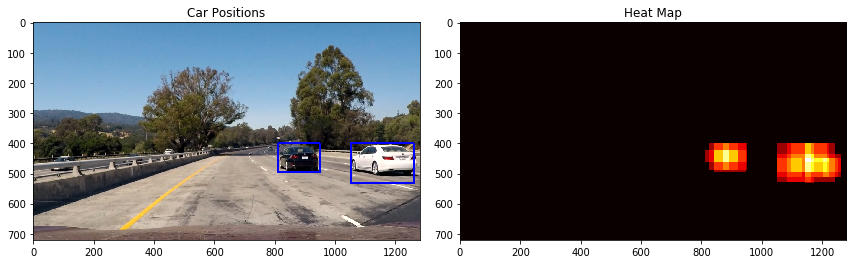

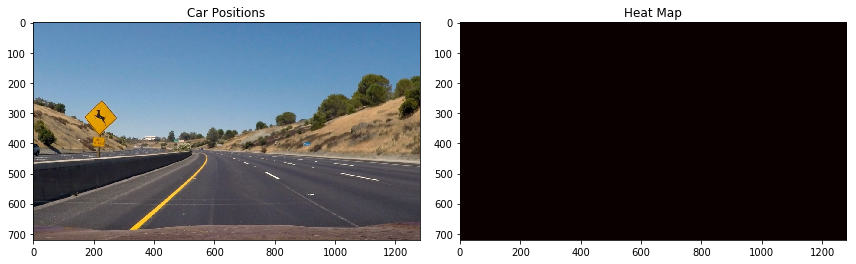

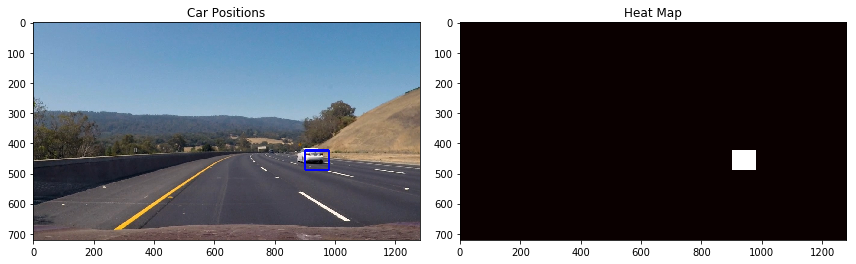

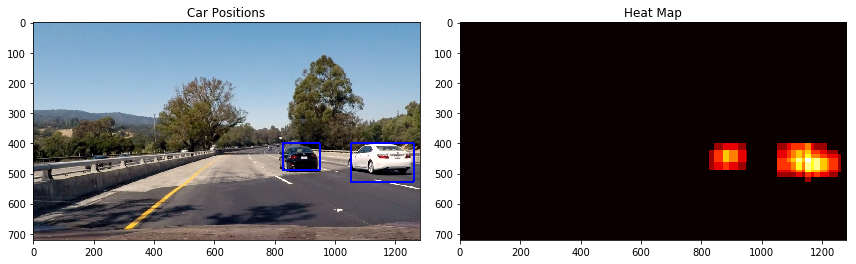

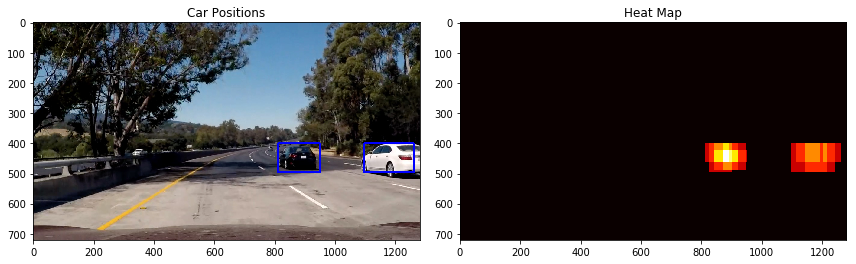

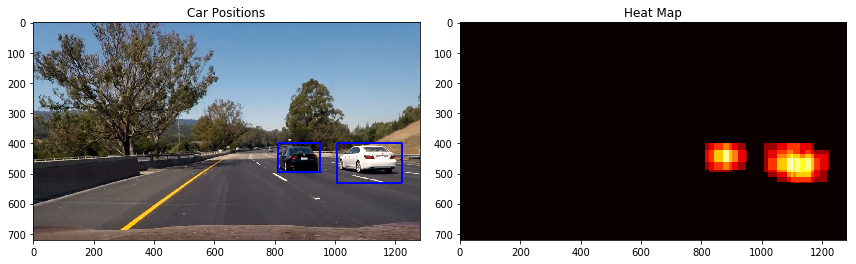

In [14]:
test_imgs = glob.glob('./test_images/*.jpg')
for file_img in test_imgs:
    image = mpimg.imread(file_img)
    CarDetection = Detection()
    labels, heatmap = get_labels(image, svc, X_scaler)
    draw_img = draw_labeled_bboxes(image, labels)
    fig = plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(draw_img)
    plt.title('Car Positions')
    plt.subplot(122)
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')
    fig.tight_layout()
    plt.show()

In [19]:
# Create a clip to see the result
from moviepy.editor import VideoFileClip
from IPython.display import HTML
CarDetection = Detection()
test_output = "project_video_result.mp4"
clip = VideoFileClip("project_video.mp4")#.subclip(24,26)
test_clip = clip.fl_image(process_image)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:05:45<00:03,  3.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 



In [20]:
HTML("""
<video width="960" height="540" controls>
<source src="{0}">
</video>
""".format(test_output))